In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SkPerceptron
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)

### Problem 1
**(1) Use Python to generate a 2D ($x_i \in \mathcal{R}^2$) linearly separable data set with 50 data points. The data set should have approximately half positive and half negative instances. Create a scatter plot to visualize the data set. Split the data set into training set (60%) and test set (40%)**

In [2]:
# Set random seed
np.random.seed(120948)

# Generate 50 random 2D points
X = np.random.randn(50, 2)

# Define a linear boundary (e.g., y = 0)
# Points above the line → class 1, below → class -1
y = np.where(X[:, 1] > 0, 1, -1)

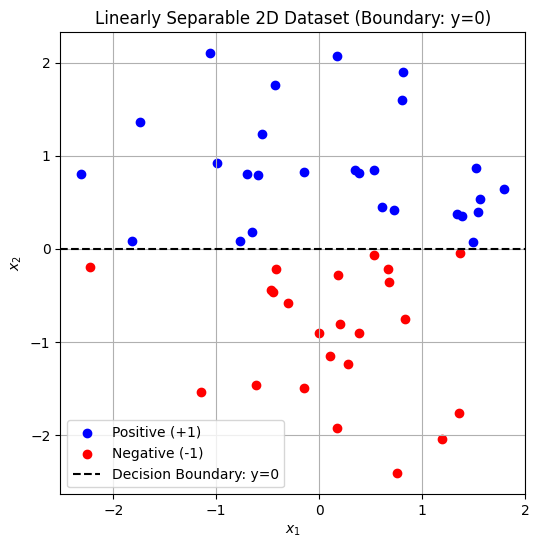

In [3]:
# Graphing datapoints
plt.figure(figsize=(6,6))
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Positive (+1)')
plt.scatter(X[y==-1, 0], X[y==-1, 1], color='red', label='Negative (-1)')

# Decision boundary: y = 0
plt.axhline(0, color='k', linestyle='--', label='Decision Boundary: y=0')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Linearly Separable 2D Dataset (Boundary: y=0)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Split data into training (60%) and test (40%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Add bias column to training data
X_train_aug = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test_aug  = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

print(f"Training set size: {len(X_train)} of {len(X)} data points")
print(f"Test set size: {len(X_test)} of {len(X)} data points")

Training set size: 30 of 50 data points
Test set size: 20 of 50 data points


**(2) Use Python (not sklearn package) to create the Batch Perceptron training algorithm and use the training data set in 1.(1) to train a Perceptron model. Plot the error function curve when the training process converges. Create a plot that shows the training instances and the learnt decision boundary.**

In [5]:
# Perceptron
class Perceptron:
    def __init__(self, X_train, y_train, lr, epochs=100, epsilon=1e-5):
        self.n, _ = X_train.shape
        self.X_train = np.c_[np.ones(self.n), X_train]
        _, self.d = self.X_train.shape
        self.W = np.random.randn(self.d, 1) * 0.01  # small random init
        self.epochs = epochs
        self.lr = lr
        self.epsilon = epsilon
        self.y_true = y_train.reshape(-1, 1)  # ensure 2D column vector

    def activation_fn(self, x):
        """Step activation function."""
        return 2 * (x > 0) - 1

    def predict(self, x):
        """Predict labels for input data."""
        z = x.dot(self.W)
        return self.activation_fn(z)

    def seq_fit(self, verbose=False, plot=False):
        errors, weight_history = [], []
        for epoch in range(self.epochs):
            for i in range(self.n):
                y_pred = self.predict(self.X_train[i])
                if y_pred.item() != self.y_true[i]:  # fix comparison
                    self.W += self.lr * (self.y_true[i] * self.X_train[i].reshape((self.d, 1)))
                    weight_history.append(self.W.copy())
            err = self.error()
            errors.append(err)
            if verbose:
                print(f"Epoch {epoch}, Error={err}")
            if np.all(np.squeeze(self.predict(self.X_train)) == np.squeeze(self.y_true)):
                break
        return self.W, errors, epoch + 1, weight_history

    def batch_fit(self, verbose=False, plot=False):
        errors = []
        for epoch in range(self.epochs):
            y_pred = self.predict(self.X_train)
            misclassified = (y_pred != self.y_true).flatten()
            if not np.any(misclassified):
                break
            update = np.sum(self.y_true[misclassified] * self.X_train[misclassified], axis=0).reshape((self.d, 1))
            self.W += self.lr * update
            err = self.error()
            errors.append(err)
            if verbose:
                print(f"Epoch {epoch}, Error={err}")
        return self.W, errors, epoch + 1

    def error(self, X_test=None, y_test=None):
        """Compute squared error on train or test data."""
        if X_test is None:
            diff = self.y_true - self.predict(self.X_train)
        else:
            diff = y_test - self.predict(X_test)
        return (diff.T @ diff)[0, 0]

    def plot(self, a, b, bias, epoch):
        """Plot decision boundary."""
        y = self.y_true.ravel()
        plt.plot(self.X_train[:, 1][y == -1], self.X_train[:, 2][y == -1], 'yo')
        plt.plot(self.X_train[:, 1][y == 1], self.X_train[:, 2][y == 1], 'ro')

        xx = np.linspace(-1, 11, 5000)
        yy = (a * xx + bias) / (-b)
        plt.plot(xx, yy, 'b')

        plt.title(f"Epoch {epoch}")
        plt.xlim(np.min(self.X_train[:, 1]) - 1, np.max(self.X_train[:, 1]) + 1)
        plt.ylim(np.min(self.X_train[:, 2]) - 1, np.max(self.X_train[:, 2]) + 1)
        plt.show()


In [6]:
p_batch = Perceptron(X_train, y_train, lr=0.01, epochs=100)
W_batch, errors_batch, epochs_batch = p_batch.batch_fit(verbose=True)

Epoch 0, Error=44
Epoch 1, Error=12
Epoch 2, Error=8
Epoch 3, Error=4
Epoch 4, Error=0


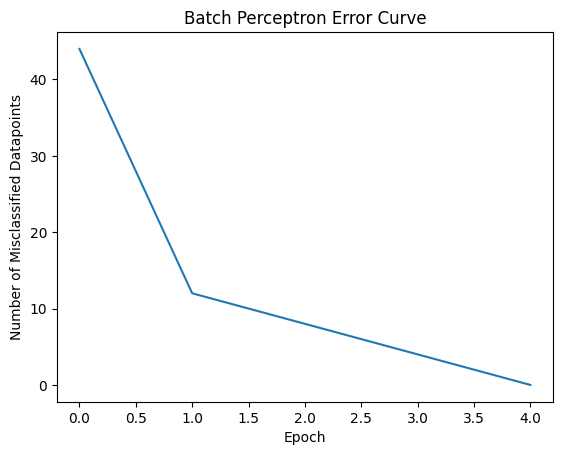

In [7]:
# Plot error curve
plt.plot(range(len(errors_batch)), errors_batch)
plt.title("Batch Perceptron Error Curve")
plt.xlabel("Epoch")
plt.ylabel("Number of Misclassified Datapoints")
plt.show()

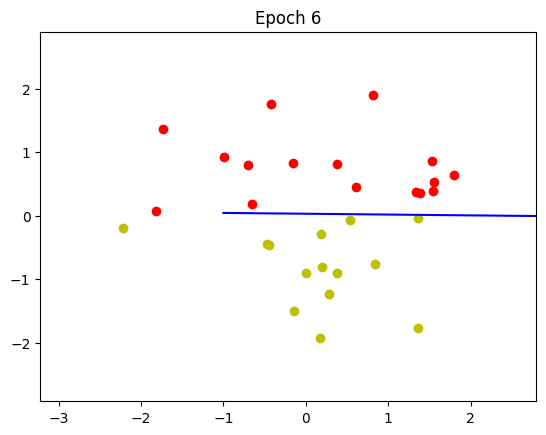

In [8]:
# Plot decision boundary
p_batch.plot(p_batch.W[1], p_batch.W[2], p_batch.W[0], epochs_batch)

**(3) Use the test set in 1.(1) to test the trained model obtained in 1.(2) and calculate the accuracy (error rate) of the trained model**

In [9]:
# Add bias term
X_test_aug = np.c_[np.ones(X_test.shape[0]), X_test]

# Predict
y_pred_batch = p_batch.predict(X_test_aug)

# Ensure y_pred_batch and y_test are 1D arrays of the same shape
y_pred_batch = y_pred_batch.flatten()
y_test = y_test.flatten()

# Count correct predictions
correct_predictions = np.sum(y_pred_batch == y_test)

# Compute accuracy correctly
total_samples = len(y_test)
acc_batch = correct_predictions / total_samples

# Print results
print(f"Correctly predicted: {correct_predictions} / {total_samples}")
print(f"Batch Perceptron Test Accuracy: {acc_batch * 100:.2f}%")

Correctly predicted: 20 / 20
Batch Perceptron Test Accuracy: 100.00%


**(4) Use Python (not sklearn package) to create the sequential Perceptron training algorithm and use the training data set in 1.(1) to train a Perceptron model. Plot the weights vs iterations curve when the training process converges. Create a plot that shows the training instances and the resulting decision boundary.**

In [10]:
p_seq = Perceptron(X_train, y_train, lr=0.01, epochs=100)
W_seq, errors_seq, epochs_seq, weight_hist = p_seq.seq_fit(verbose=True)

Epoch 0, Error=8
Epoch 1, Error=12
Epoch 2, Error=0


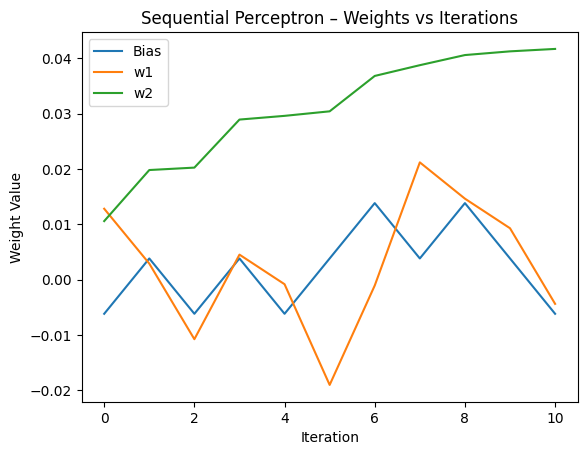

In [11]:
# Plot weights vs iterations
weights_array = np.array(weight_hist).reshape(-1, 3)
plt.plot(weights_array)
plt.title("Sequential Perceptron – Weights vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Weight Value")
plt.legend(["Bias", "w1", "w2"])
plt.show()

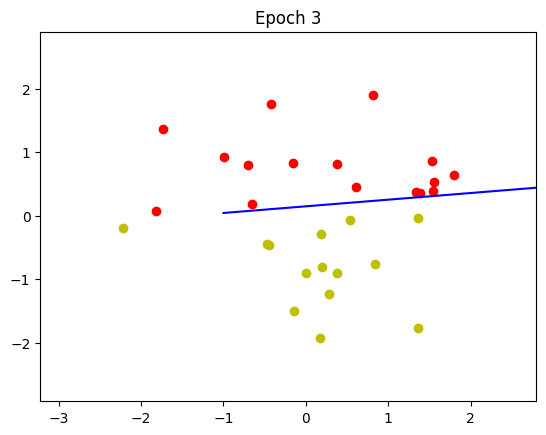

In [12]:
# Plot decision boundary
p_seq.plot(p_seq.W[1], p_seq.W[2], p_seq.W[0], epochs_seq)

**(5) Use the test set in 1.(1) to test the trained model obtained in 1. (4) and calculate the accuracy (error rate) of the trained model.**

In [13]:
# Predict using sequential perceptron
y_pred_seq = p_seq.predict(X_test_aug).flatten()

# Flatten arrays to ensure matching shapes
y_test = y_test.flatten()

# Count number of correct predictions
correct_predictions_seq = np.sum(y_pred_seq == y_test)

# Compute accuracy
total_samples_seq = len(y_test)
acc_seq = correct_predictions_seq / total_samples_seq

# Print results
print(f"Correctly predicted: {correct_predictions_seq} / {total_samples_seq}")
print(f"Sequential Perceptron Test Accuracy: {acc_seq * 100:.2f}%")

Correctly predicted: 19 / 20
Sequential Perceptron Test Accuracy: 95.00%


**(6) Show how you select learning rate during the training process of 1.(2) or 1.(4) and demonstrate how the choice of the learning rate is affecting the convergence of the training process.**

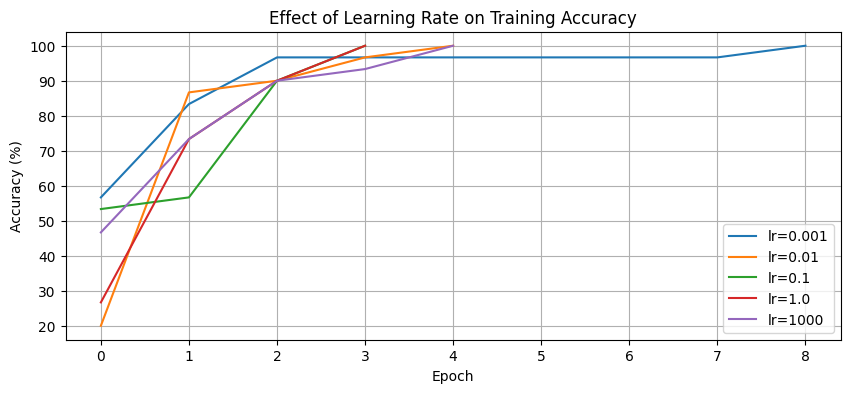

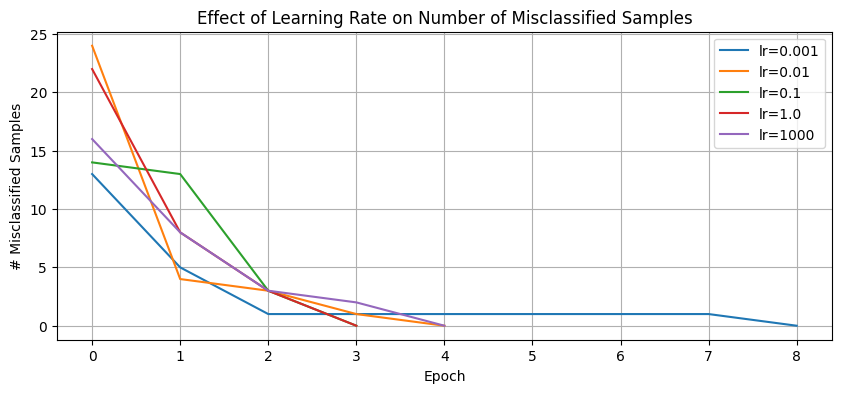

In [14]:
etas = [0.001, 0.01, 0.1, 1.0, 1000]
max_epochs = 50

acc_histories = []
mis_histories = []

for eta in etas:
    p = Perceptron(X_train, y_train, lr=eta, epochs=max_epochs)
    
    acc_per_epoch = []
    mis_per_epoch = []
    
    # manual batch training loop to capture every epoch's stats
    for epoch in range(p.epochs):
        y_pred = p.predict(p.X_train)
        
        # compute accuracy and misclassified count
        correct = np.sum(y_pred == p.y_true)
        total = len(p.y_true)
        acc = correct / total
        misclassified = total - correct
        
        acc_per_epoch.append(acc)
        mis_per_epoch.append(misclassified)
        
        # compute weight update for this epoch
        mis_mask = (y_pred != p.y_true).flatten()
        if not np.any(mis_mask):
            # converged
            break
        
        update = np.sum(p.y_true[mis_mask] * p.X_train[mis_mask], axis=0).reshape((p.d, 1))
        p.W += p.lr * update

    acc_histories.append((eta, acc_per_epoch))
    mis_histories.append((eta, mis_per_epoch))

# ===== Plot Accuracy vs Epochs =====
plt.figure(figsize=(10,4))
for eta, accs in acc_histories:
    plt.plot(np.arange(len(accs)), np.array(accs) * 100, label=f"lr={eta}")
plt.title("Effect of Learning Rate on Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# ===== Plot Misclassified Samples vs Epochs =====
plt.figure(figsize=(10,4))
for eta, misses in mis_histories:
    plt.plot(np.arange(len(misses)), misses, label=f"lr={eta}")
plt.title("Effect of Learning Rate on Number of Misclassified Samples")
plt.xlabel("Epoch")
plt.ylabel("# Misclassified Samples")
plt.legend()
plt.grid(True)
plt.show()


As evident in the graphs above, learning rate (lr) has an impact on the number of epochs needed for our model to converge. If our lr is too small, it takes a marge number of epochs to converge.

### Problem 2
**(a) Use the make_classification method in sklearn to create a binary linearly separable data set with two (2) features and 100 data points. Visualize the data set.

Split the dataset into to training and test data sets using the train_test_split method in sklearn.

Use the training set to train the Perceptron model in sklearn then use the trained model to make prediction on the test set.

Calculate the accuracy of the classification

Visualize the decision boundary of the trained Perceptron model on top of the test data
points. **

In [15]:
# data: clearly linearly separable
X_lin, y_lin = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=2.0, random_state=42
)

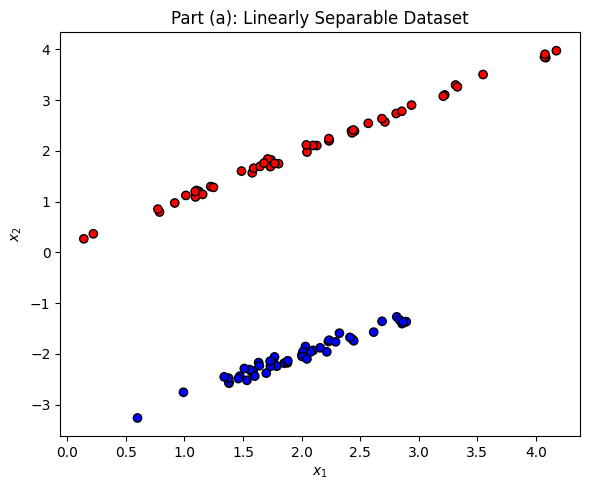

In [16]:
# visualize dataset
plt.figure(figsize=(6,5))
plt.scatter(X_lin[:,0], X_lin[:,1], c=y_lin, cmap='bwr', edgecolors='k')
plt.title("Part (a): Linearly Separable Dataset")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.tight_layout()
plt.show()


In [17]:
# split
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_lin, y_lin, test_size=0.30, random_state=42, stratify=y_lin)

In [18]:
# --- compatible constructor (older sklearn) ---
clf_a = SkPerceptron(max_iter=1000, eta0=0.1, tol=1e-3, random_state=0)
clf_a.fit(Xa_tr, ya_tr)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,eta0,0.1
,n_jobs,None
,random_state,0


In [19]:
# predict + accuracy
ya_pred = clf_a.predict(Xa_te)
acc_a = accuracy_score(ya_te, ya_pred)
print(f"[Part (a)] Test Accuracy: {acc_a*100:.2f}%")

[Part (a)] Test Accuracy: 100.00%


In [20]:
# function for plotting the decision boundary
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

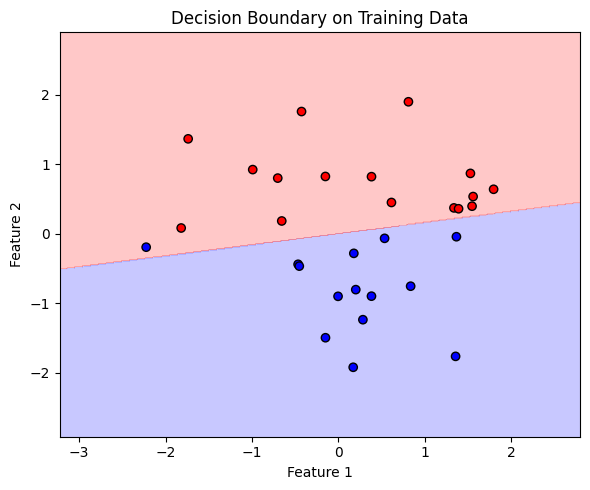

In [21]:
# visualize decision boundary on training data
plot_decision_boundary(clf_a, X_train, y_train,
                       "Decision Boundary on Training Data")

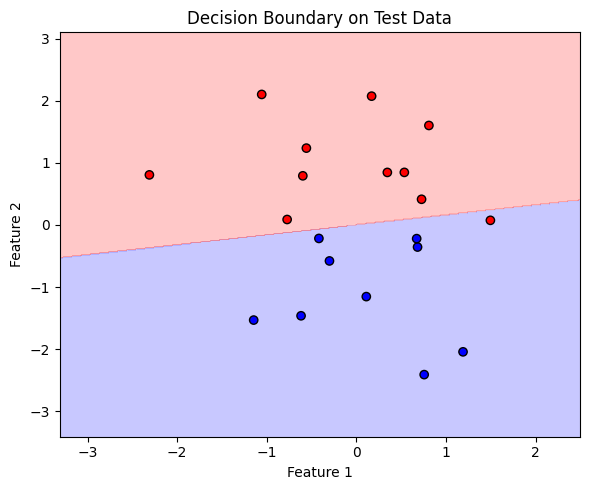

In [22]:
# visualize decision boundary on test data
plot_decision_boundary(clf_a, X_test, y_test,
                       "Decision Boundary on Test Data")

**(b)
Use the make_classification method in sklearn to create a binary non linearly separable data set with two (2) features and 100 data points. The data set should have class imbalance. Visualize the data set.

Split the dataset into to training and test data sets using the train_test_split method in sklearn.

Use the training set to train the Perceptron model in sklearn then use the trained model to make prediction on the test set.

Use sklearn.metrics to show the following on the classification results:

Accuracy, Precision, Recall, F1 score

The classification_report and the confusion_matrix

Visualize the decision boundary of the trained Perceptron model on top of the test data
points.
**

In [23]:
# data: overlap + imbalance (70/30), slight label noise
X_non, y_non = make_classification(
    n_samples=100, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=0.6, flip_y=0.03,
    weights=[0.70, 0.30], random_state=7
)

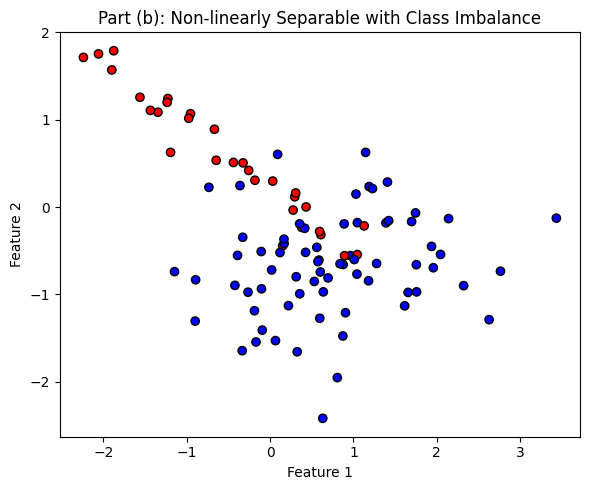

In [24]:
# visualize dataset
plt.figure(figsize=(6,5))
plt.scatter(X_non[:,0], X_non[:,1], c=y_non, cmap='bwr', edgecolors='k')
plt.title("Part (b): Non-linearly Separable with Class Imbalance")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()

In [25]:
# split (stratify preserves imbalance)
Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
    X_non, y_non, test_size=0.30, random_state=7, stratify=y_non
)

In [26]:
# train sklearn perceptron
clf_b = SkPerceptron(max_iter=2000, eta0=0.1, tol=1e-3, random_state=0)
clf_b.fit(Xb_tr, yb_tr)

,penalty,None
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,0.001
,shuffle,True
,verbose,0
,eta0,0.1
,n_jobs,None
,random_state,0


In [27]:
# predictions
yb_pred = clf_b.predict(Xb_te)

In [28]:
# metrics
acc_b = accuracy_score(yb_te, yb_pred)
prec_b = precision_score(yb_te, yb_pred, zero_division=0)
rec_b  = recall_score(yb_te, yb_pred, zero_division=0)
f1_b   = f1_score(yb_te, yb_pred, zero_division=0)

print("\n[Part (b)] Metrics on Test Set")
print(f"Accuracy : {acc_b*100:.2f}%")
print(f"Precision: {prec_b:.3f}")
print(f"Recall   : {rec_b:.3f}")
print(f"F1 Score : {f1_b:.3f}")

print("\nClassification Report:")
print(classification_report(yb_te, yb_pred, digits=3, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(yb_te, yb_pred))


[Part (b)] Metrics on Test Set
Accuracy : 83.33%
Precision: 1.000
Recall   : 0.444
F1 Score : 0.615

Classification Report:
              precision    recall  f1-score   support

           0      0.808     1.000     0.894        21
           1      1.000     0.444     0.615         9

    accuracy                          0.833        30
   macro avg      0.904     0.722     0.755        30
weighted avg      0.865     0.833     0.810        30

Confusion Matrix:
[[21  0]
 [ 5  4]]


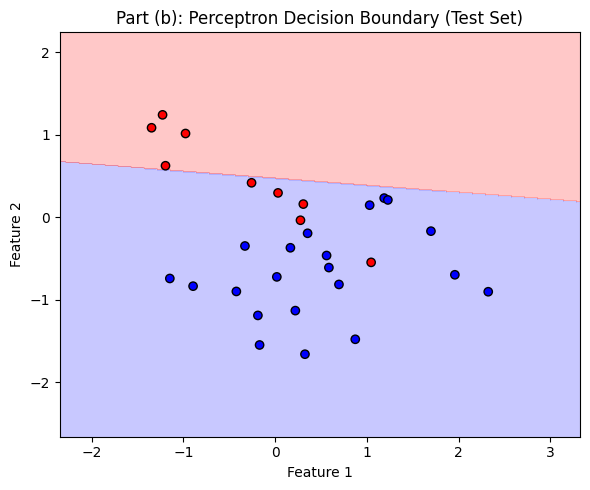

In [29]:
# decision boundary on test set
plot_decision_boundary(clf_b, Xb_te, yb_te, title="Part (b): Perceptron Decision Boundary (Test Set)")